# End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them). 


In [1]:
# Mount your drive and unzip the uploaded data
# !cd "/content/drive/My Drive/Dog Breed Kaggle/"
# from google.colab import drive
# drive.mount('/content/drive/My Drive/Dog Breed Kaggle/')
# !unzip "/content/drive/My Drive/Dog Breed Kaggle/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Breed Kaggle/"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get our workspace ready

* Import TensorFlow 
* Import TensorFlow Hub
* Make sure we're using a GPU

In [2]:
# Import TensorFlow, TensorFlowHub into Colab
import tensorflow as tf
import tensorflow_hub as hub

# Check for GPU availability
print("GPU is Available" if  tf.config.list_physical_devices("GPU") else "GPU is not available")

GPU is Available


## Getting our data ready (Turning data into Tensors)

With all ML models, our data has to be in numerical format. So that's what we'll be doing first.   
Turning our images into Tensors (Numerical Expressions)

Let's start by accessing our data and checking out the labels.
 

In [3]:
# Checkout the labels of our data

import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog Breed Kaggle/labels.csv")


In [4]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,6da4c7ee12790d8047e82c7750884780,scottish_deerhound
freq,1,126


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


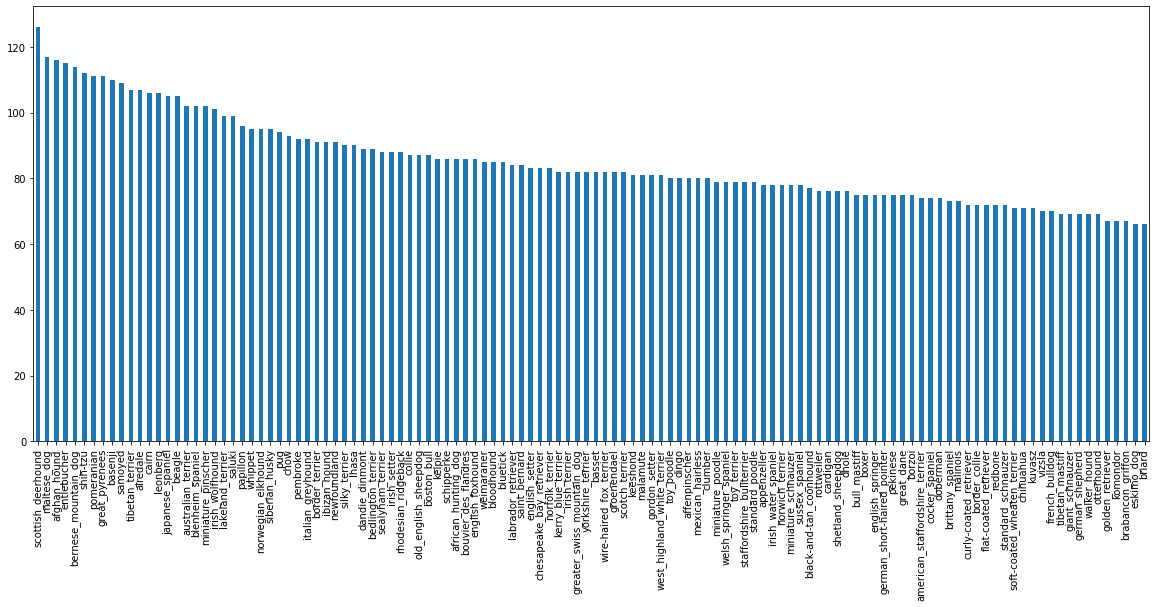

In [6]:
# How many images are there of each bread
labels_csv["breed"].value_counts().plot(kind = "bar", figsize = (20, 8));

### Getting images and thier label

Let's get a list of all our images file path names

In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
# Create pathnames from image ID's
filenames = ["/content/drive/My Drive/Dog Breed Kaggle/train/" + fname + ".jpg" for fname in labels_csv["id"]]


In [9]:
#check the first name
filenames[:10]

['/content/drive/My Drive/Dog Breed Kaggle/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# check wheater number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/My Drive/Dog Breed Kaggle/train")) == len(filenames):
  print("Number of files Matched")
else:
  print("Number of files do not Match") 

Number of files Matched


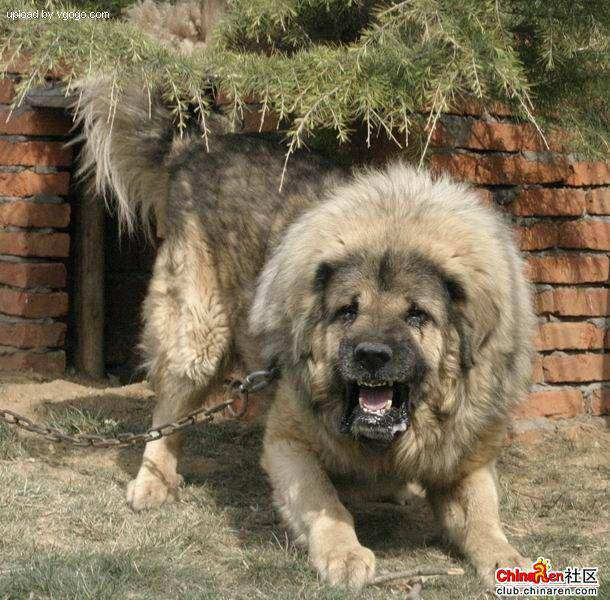

In [11]:
# One more check
from IPython.display import Image
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000] #name of the breed in the image above

'tibetan_mastiff'

Since we'have now got out training imahe filepaths in a list, let's prepare our labels.

In [13]:
import numpy as np
#convert to label
labels = labels_csv["breed"].to_numpy() 
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# see if number of labels matches the number of filenames

if len(labels) == len(filenames):
  print("Label count match")
else:
  print("Labels count doesn't match")

Label count match


In [16]:
# find the unique label values  
unique_breeds = np.unique(labels)
len(unique_breeds), unique_breeds[:10]

(120,
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle'], dtype=object))

In [17]:
# Turn a single label into an array of boolean
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
len(boolean_labels) 

10222

In [20]:
# Example : Turning boolean array into integers
# this is nothing but onehotencoding
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # this prints index of max value where label occurs in boolean array
print(boolean_labels[0].astype(int)) # boolean into number

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
filenames[:10] #these are patch of each file, but they are yet to be converted in tensors

['/content/drive/My Drive/Dog Breed Kaggle/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Dog Breed Kaggle/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set  

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [23]:
# Setup X and Y varibale

X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [24]:
# Set number of images to use for experimenting

#Consider this as hyperparameter and hence it is capital
#this slider is a colab function, not jupyter in gerneral
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step :1000}

In [25]:
# Split the data

from sklearn.model_selection import train_test_split

#split them into training and validation of total size NUM_images
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [26]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['/content/drive/My Drive/Dog Breed Kaggle/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/My Drive/Dog Breed Kaggle/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False,

## Preprocessing Imges (Turning Images into Tensors)

To preprocess our images into tensors we are going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our image (convert color channel values from 0-225 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like

In [27]:
#convert image into NumPy Array
from matplotlib.pyplot import imread

image = imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(), image.min()

(255, 0)

In [29]:
image[:2]


array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [30]:
#turn images into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Let's make the function to convert image into tensor

In [31]:
# Define Image size, to feed a constant size to the model
IMG_SIZE = 224 

# create a function preprocessing images

def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  # read in an image file
  image = tf.io.read_file(image_path)

  # turn jpg into numerical tensor with RBG,        why are we not using tf.constant
  image = tf.image.decode_jpeg(image, channels = 3)

  # Convert the colour channel values 0-255 to 0-1, to make the computation more efficient
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize to (244, 244)
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image 

## Turning our data into batches

We are turning data into batches (usually 32), because the GPU have a limited amount of memory and all the train sample might not fit into memory

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this : `(image, label)`

In [32]:
# create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  takes an image file path name and the associated label,
  process the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [33]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of Tensors in the form `image, label`, let's make a function to turn all of our data (`x` and `y`) into batches!

In [34]:
# Define the batch size, 32 is a good start and it is default anyway
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of images (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  """

  if test_data: #no labels
    print("Creating test data batches..")


    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only pathes
    
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data: #no need to shuffle
    print("Creating validation data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepath
                                              tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch 
  
  else: #training set, requires shuffle
    print("Creating training data batches..")

    #turning into Pathnames and labels into Tensors 
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # shuffling pathnames and labels before the mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image) and then turn them into batches
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [35]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches..
Creating validation data batches..


In [36]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Our data is now batches, however, for better understanding, these are the visulaztion

In [37]:
import matplotlib.pyplot as plt

# To view images in a data batch
def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels form a data batch
  """
  # Setup the figure
  plt.figure(figsize = (10, 10))

  # Loop through 25 (for)
  for i in range(25):
    # create subplot (5 row, 5 column)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

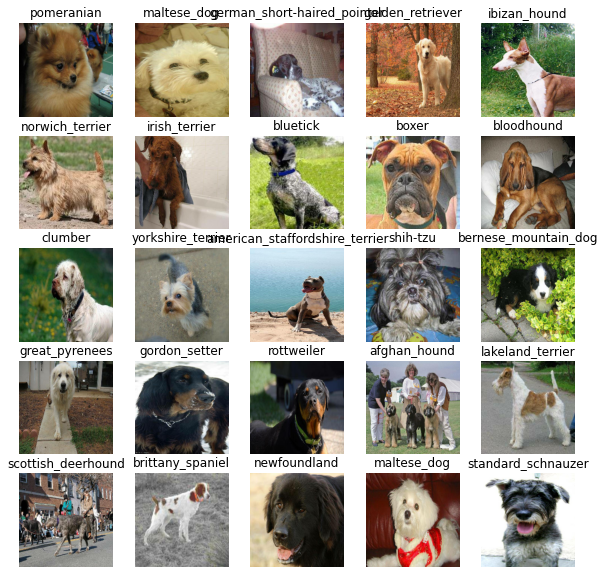

In [38]:
# Let's visulize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

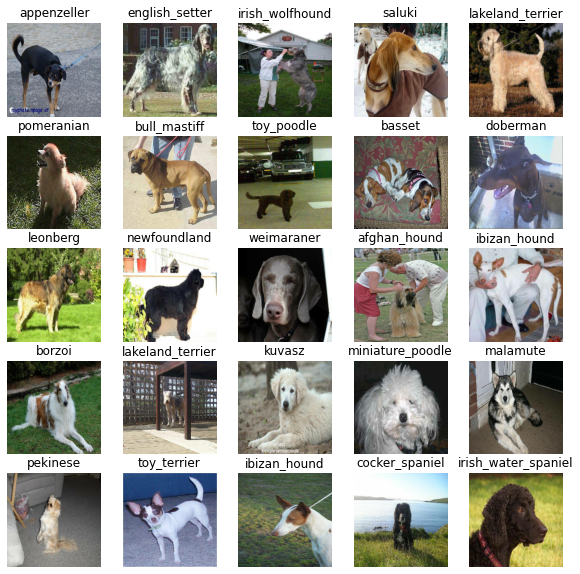

In [39]:
# Let's visulize the data in a validation batch
val_images, val_labels = next(train_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few thinds we need to define:
* The input shape (our image shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from [TensorFlow Hub](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4).

In [40]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #Batch size, height, weight, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds) # array in which the correct label will be true and others will be false

# setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got out inputs, output and model ready to go.
Let's put them together into a keras deep learning model!

Knowing this, let's create a function:
* Takes the input shape, output shape and the model
* Defines the layers in a Keras model in sequential fashion (first this, then this, then that)
* Complies the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model


In [43]:
# Create a function which builds a Keras model

def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Model Building Initiated...")

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Input Layer
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE, 
                                                     activation = 'softmax') # output layer
  ])

  # compile the model 
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )

  # build the model
  model.build(INPUT_SHAPE)

  return model

In [45]:
model = create_model()
model.summary()

Model Building Initiated...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


223 MobileNetV2-the-model-were-using-architecture-explanation-by-Sik-Ho-Tsang
https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c  

223 Step-by-step-breakdown-of-a-convolutional-neural-network-what-MobileNetV2-is-made-of-
https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53  


224 -Article-How-to-choose-loss-activation-functions-when-building-a-deep-learning-model
https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

## Creating Callbacks
 
Callbacks are helper function a model can use during training to do such things as save it's progress, check a model stops imporving.

We'll create two callbacks, one for TensorBoard which helps track out models progress and another for early model from trining for too long.

## TensorBoard Callback

to setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to do a directory and pass it to our model's `fit()` function
3. Visulize our models training logs with the `%tensorboard` magic function (we'll do this model training)

In [47]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [49]:
import datetime

# create a function to build a TensorBoard callback (save logs)
def create_tensorboard_callback():
  # Create a log diretory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/My Drive/Dog Breed Kaggle/Logs", 
                        # make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stoping Callback

Early stopping help stops out model form overfitting by stopping training if a certain evaluation metrics stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [50]:
# Create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=3)